# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
  1.0
  ⋮
  1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0

### We create a function to visualize the data

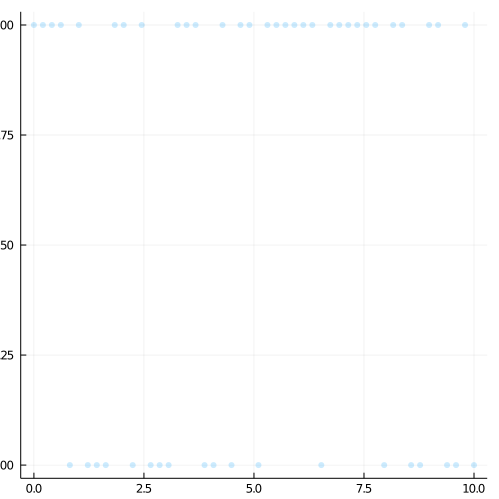

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.478572 seconds (1.15 M allocations: 67.482 MiB, 99.33% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:03:58
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:01
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:21
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:00
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:30
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:24
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:20
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[1.779424384544448, 1.8050279965944283, 1.698464164670836, 1.456066267315264, 1.1376541917208156, 0.8210423973767285, 0.5192201085981131, 0.32208776802445405, 0.19260400831977006, 0.16400445382782936  …  0.3089132928615095, -0.0060927698916080075, -0.2721192601487567, -0.4911807269952062, -0.6274346852480918, -0.800538172669112, -0.9081439343564343, -0.9906764913655512, -1.0780025816701198, -1.1332998957750688]]
 [[0.469329238631106, 0.46292843275530765, 0.45750463764821564, 0.4744064961749094, 0.4499337305335268, 0.3898309661361707, 0.23766092267935185, 0.027300341252091076, -0.19975722223582695, -0.40622066522225214  …  0.05352244055398497, -0.20547759323375125, -0.46577032164521603, -0.6549219390995142, -0.7977891270131956, -0.8739582010745286, -0.8627602344735024, -0.8089295086580857, -0.7408796056443332, -0.629554897774862]]
 [[0.6100453787965354, 0.7132790884830718, 0.6797236961273443, 0.476181657877518, 0.1858598956140448, -0.10074

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

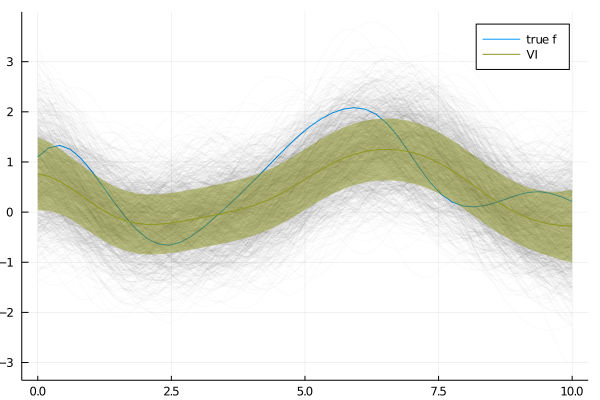

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

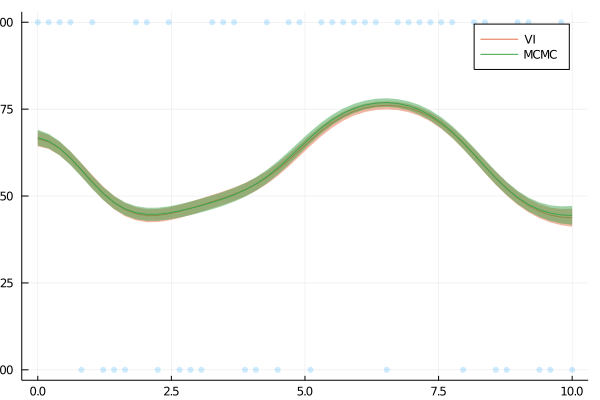

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*